In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2026-02-28 02:27:09.618026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772245629.843844      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772245629.909551      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772245630.453390      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772245630.453429      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772245630.453432      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: True


In [25]:
# Kaggle paths
data_dir = Path('/kaggle/input/datasets/emmarex/plantdisease/PlantVillage')
processed_dir = Path('/kaggle/input/datasets/samuelkarikari/plant-village-processed')
models_dir = Path('/kaggle/working/models')
models_dir.mkdir(parents=True, exist_ok=True)

# Load preprocessing config
with open(processed_dir / "preprocessing_config.json") as f:
    config = json.load(f)

# Load class mappings
with open(processed_dir / "class_to_index.json") as f:
    class_to_index = json.load(f)

with open(processed_dir / "index_to_class.json") as f:
    index_to_class = {int(k): v for k, v in json.load(f).items()}

# Load class weights
with open(processed_dir / "class_weights.json") as f:
    class_weights = {int(k): v for k, v in json.load(f).items()}

# Core config
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64
N_CLASSES = len(class_to_index)
MEAN = config['normalization']['mean']
STD = config['normalization']['std']
RANDOM_SEED = config['random_seed']

print(f"Classes: {N_CLASSES}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Normalization mean: {MEAN}")
print(f"Normalization std: {STD}")

Classes: 15
Image size: (128, 128)
Batch size: 64
Normalization mean: [0.46, 0.48, 0.42]
Normalization std: [0.21, 0.18, 0.22]


In [26]:
# Load manifests and fix paths to point to Kaggle
train_df = pd.read_csv(processed_dir / "train.csv")
val_df = pd.read_csv(processed_dir / "val.csv")
test_df = pd.read_csv(processed_dir / "test.csv")

# Fix image paths to point to Kaggle local storage
def fix_path(p):
    return str(data_dir / Path(p).parent.name / Path(p).name)

train_df['image_path'] = train_df['image_path'].apply(fix_path)
val_df['image_path'] = val_df['image_path'].apply(fix_path)
test_df['image_path'] = test_df['image_path'].apply(fix_path)

print(f"Train: {len(train_df)} images")
print(f"Val:   {len(val_df)} images")
print(f"Test:  {len(test_df)} images")
print(f"\nSample path: {train_df['image_path'].iloc[0]}")

# Verify sample path exists
print(f"File exists: {Path(train_df['image_path'].iloc[0]).exists()}")

Train: 14227 images
Val:   3049 images
Test:  3049 images

Sample path: /kaggle/input/datasets/emmarex/plantdisease/PlantVillage/Tomato_Septoria_leaf_spot/caf6c8f5-e7ba-4d75-98ef-9b2c0dffcaaa___Keller.St_CG 1792.JPG
File exists: True


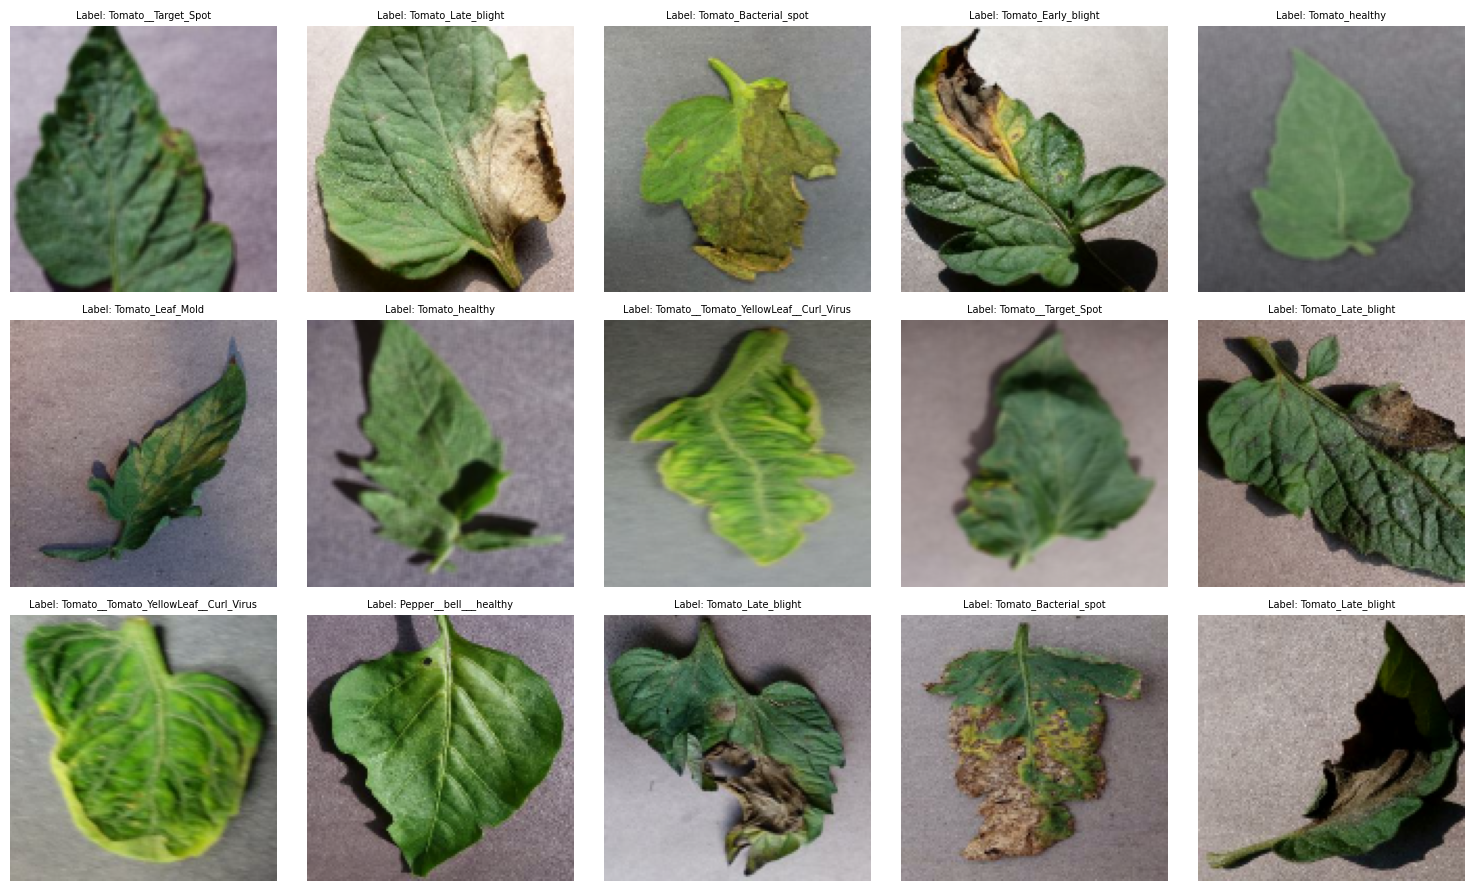


Label distribution in first 10 batches:
  Pepper__bell___Bacterial_spot: 39
  Pepper__bell___healthy: 41
  Potato___Early_blight: 29
  Potato___Late_blight: 28
  Potato___healthy: 3
  Tomato_Bacterial_spot: 64
  Tomato_Early_blight: 28
  Tomato_Late_blight: 61
  Tomato_Leaf_Mold: 35
  Tomato_Septoria_leaf_spot: 56
  Tomato_Spider_mites_Two_spotted_spider_mite: 51
  Tomato__Target_Spot: 41
  Tomato__Tomato_YellowLeaf__Curl_Virus: 104
  Tomato__Tomato_mosaic_virus: 9
  Tomato_healthy: 51


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Check a batch of images and labels
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i, ax in enumerate(axes.flat):
        # Denormalize for display
        img = images[i].numpy()
        img = (img * np.array(STD) + np.array(MEAN))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Label: {index_to_class[labels[i].numpy()]}", fontsize=7)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Check label distribution in a few batches
all_labels = []
for images, labels in train_dataset.take(10):
    all_labels.extend(labels.numpy())

unique, counts = np.unique(all_labels, return_counts=True)
print("\nLabel distribution in first 10 batches:")
for u, c in zip(unique, counts):
    print(f"  {index_to_class[u]}: {c}")

In [27]:
mean = tf.constant(MEAN, dtype=tf.float32)
std = tf.constant(STD, dtype=tf.float32)

def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - mean) / std
    return image

MINORITY_CLASSES = [
    cls for cls, idx in class_to_index.items()
    if len(train_df[train_df['class_name'] == cls]) < 500
]
print(f"Minority classes: {MINORITY_CLASSES}")

TOMATO_NOISY_CLASSES = [
    'Tomato_healthy',
    'Tomato__Target_Spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite'
]

def augment_standard(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

def augment_aggressive(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return image

def augment_denoise(image):
    image = augment_standard(image)
    image = tf.expand_dims(image, 0)
    image = tf.squeeze(
        tf.nn.avg_pool2d(image, ksize=3, strides=1, padding='SAME'), 0
    )
    return image

Minority classes: ['Potato___healthy', 'Tomato__Tomato_mosaic_virus']


In [29]:
minority_indices = [class_to_index[cls] for cls in MINORITY_CLASSES]
noisy_indices = [class_to_index[cls] for cls in TOMATO_NOISY_CLASSES if cls in class_to_index]

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = normalize(image)
    return image, label

def apply_augmentation(image, label):
    is_minority = tf.reduce_any(tf.equal(label, tf.constant(minority_indices, dtype=tf.int64)))
    is_noisy = tf.reduce_any(tf.equal(label, tf.constant(noisy_indices, dtype=tf.int64)))

    image = tf.cond(
        is_minority,
        lambda: augment_aggressive(image),
        lambda: tf.cond(
            is_noisy,
            lambda: augment_denoise(image),
            lambda: augment_standard(image)
        )
    )
    return image, label

def build_dataset(df, is_training=False, shuffle=False):
    paths = df['image_path'].values
    labels = df['class_index'].values.astype(np.int64)

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), seed=RANDOM_SEED)

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = build_dataset(train_df, is_training=True, shuffle=True)
val_dataset = build_dataset(val_df, is_training=False, shuffle=False)
test_dataset = build_dataset(test_df, is_training=False, shuffle=False)

print("Datasets built successfully")

for images, labels in train_dataset.take(1):
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    print(f"Label dtype: {labels.dtype}")

Datasets built successfully
Batch image shape: (64, 128, 128, 3)
Batch label shape: (64,)
Label dtype: <dtype: 'int64'>


In [30]:
from tensorflow.keras import regularizers

def build_cnn(input_shape=(128, 128, 3), n_classes=15):
    inputs = keras.Input(shape=input_shape)
    l2 = regularizers.l2(1e-4)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 4
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_cnn(input_shape=(128, 128, 3), n_classes=N_CLASSES)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 726,319 (2.77 MB)

 Trainable params: 723,887 (2.76 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [31]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
training_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=str(models_dir / 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [34]:
EPOCHS = 100

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=training_callbacks,
    verbose=1
)

print("Training complete.")

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3151 - loss: 2.3634
Epoch 1: val_loss improved from inf to 3.65074, saving model to /kaggle/working/models/best_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 52s 177ms/step - accuracy: 0.3156 - loss: 2.3611 - val_accuracy: 0.1922 - val_loss: 3.6507 - learning_rate: 1.0000e-04
Epoch 2/100
222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6169 - loss: 1.2199
Epoch 2: val_loss did not improve from 3.65074
223/223 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.6172 - loss: 1.2192 - val_accuracy: 0.2076 - val_loss: 3.7742 - learning_rate: 1.0000e-04
Epoch 3/100
222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7114 - loss: 0.9172
Epoch 3: val_loss did not improve from 3.65074
223/223 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7115 - loss: 0.9169 - val_accuracy: 0.3037 - val_loss: 4.5181 - learning_rate: 1.0000e-04
Epoch 4/100
222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7537 - loss: 0.7777
Ep

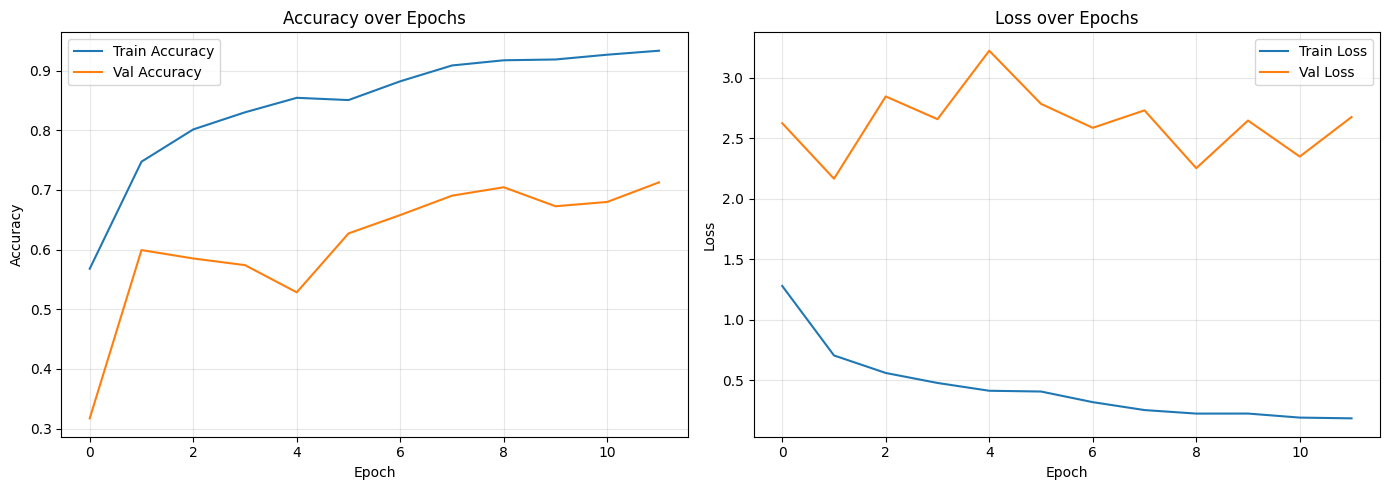

In [21]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Accuracy over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Loss over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(str(models_dir / 'training_curves.png'), dpi=150)
    plt.show()

plot_training_history(history)

In [22]:
best_model = keras.models.load_model(str(models_dir / 'best_model.keras'))

test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.5901 - loss: 2.2077

Test Loss:     2.1894
Test Accuracy: 0.5940


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.69      0.81      0.75       150
                     Pepper__bell___healthy       0.87      0.78      0.83       221
                      Potato___Early_blight       0.84      0.89      0.86       150
                       Potato___Late_blight       0.35      0.91      0.51       150
                           Potato___healthy       0.03      0.13      0.05        23
                      Tomato_Bacterial_spot       0.75      0.89      0.82       316
                        Tomato_Early_blight       0.61      0.58      0.60       148
                         Tomato_Late_blight       0.48      0.67      0.56       259
                           Tomato_Leaf_Mold       0.87      0.73      0.80       142
                  Tomato_Septoria_leaf_spot       0.48      0.68      0.56       264
Tomato_Spider_mites_Two_spotted_spider_mite       0.00      0.00

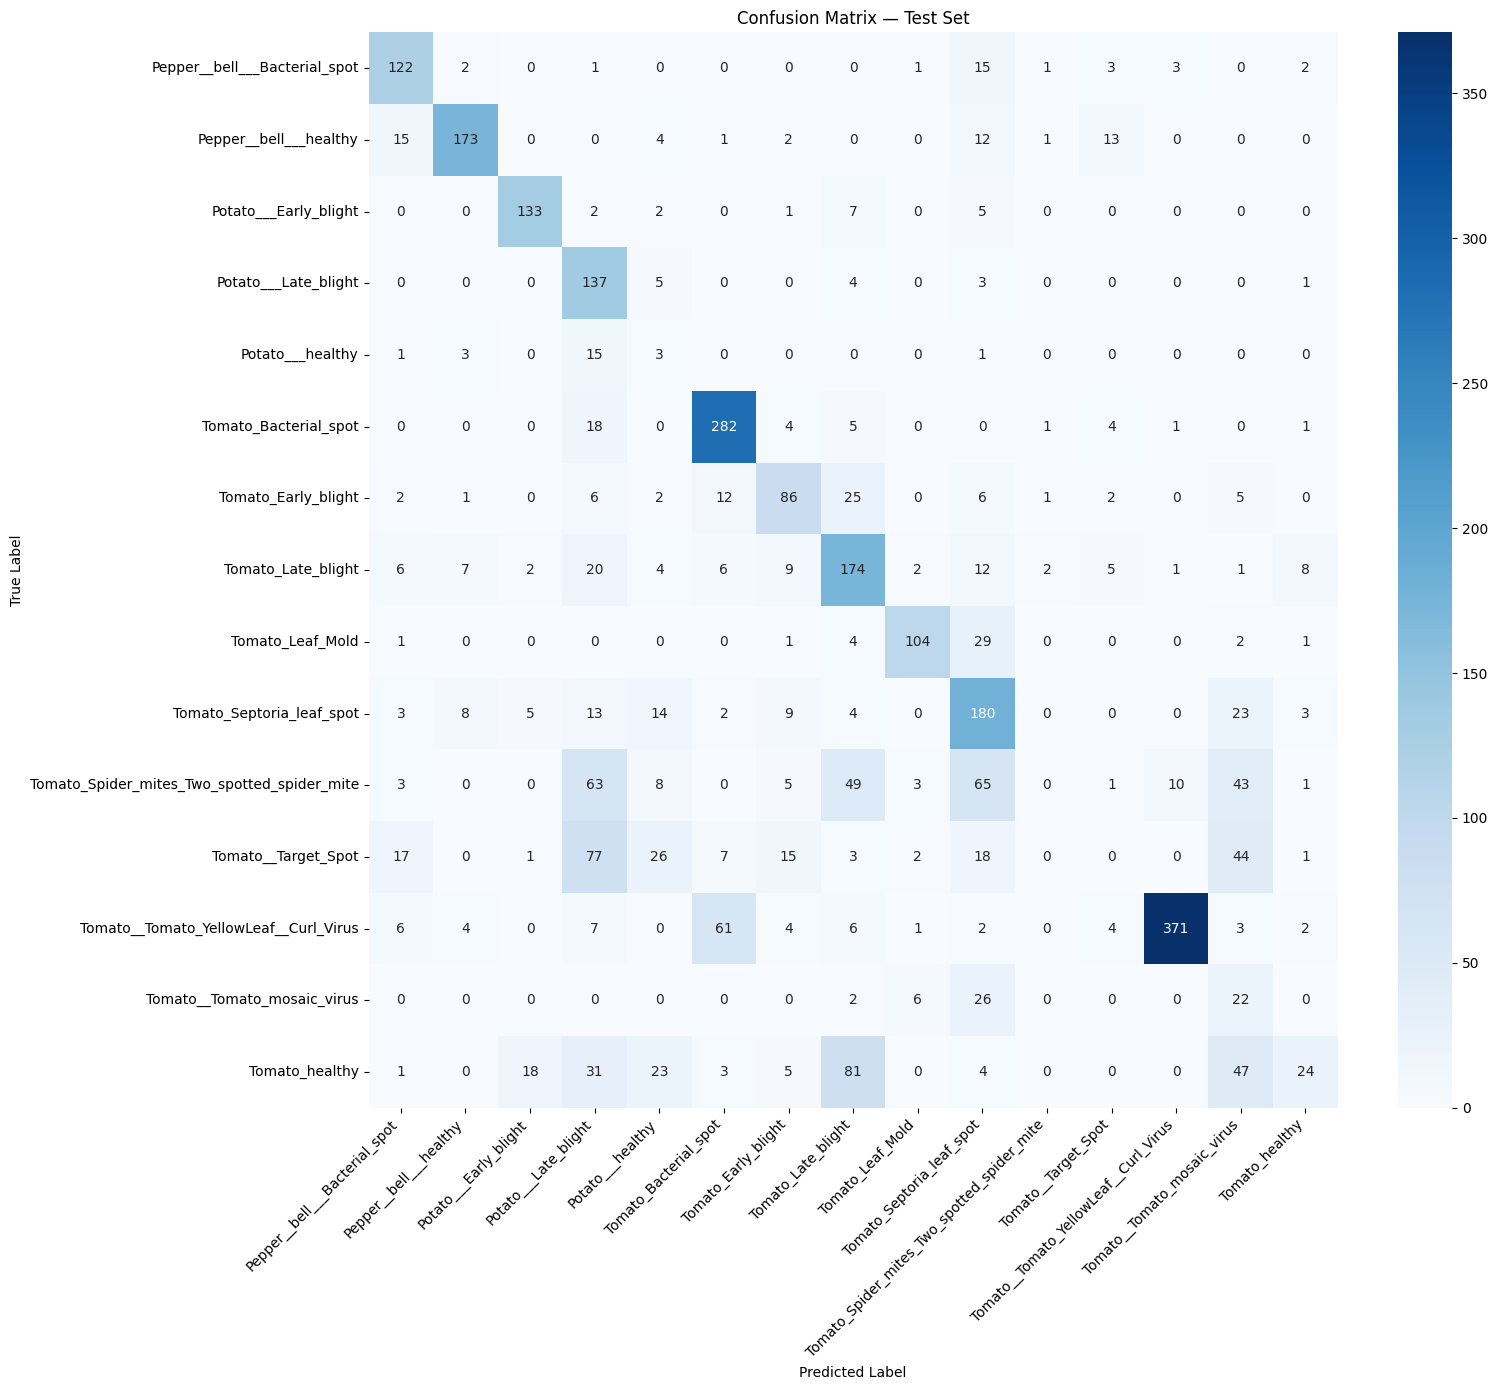

In [23]:
class_names = [index_to_class[i] for i in range(N_CLASSES)]
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix — Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(str(models_dir / 'confusion_matrix.png'), dpi=150)
plt.show()

In [24]:
flagged_classes = ['Potato___healthy', 'Tomato__Tomato_mosaic_virus']

print("Per-class accuracy for flagged minority classes:")
for class_name in flagged_classes:
    idx = class_to_index[class_name]
    mask = y_true == idx
    if mask.sum() > 0:
        acc = (y_pred[mask] == y_true[mask]).mean()
        print(f"  {class_name}: {acc:.4f} ({mask.sum()} test images)")

Per-class accuracy for flagged minority classes:
  Potato___healthy: 0.1304 (23 test images)
  Tomato__Tomato_mosaic_virus: 0.3929 (56 test images)
